In [1]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import xpart as xp
import yaml

In [2]:
collider = xt.Multiline.from_json('../data/collider.json')
collider.build_trackers()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [3]:
twiss_b1 = collider['lhcb1'].twiss()
twiss_b2 = collider['lhcb2'].twiss().reverse()

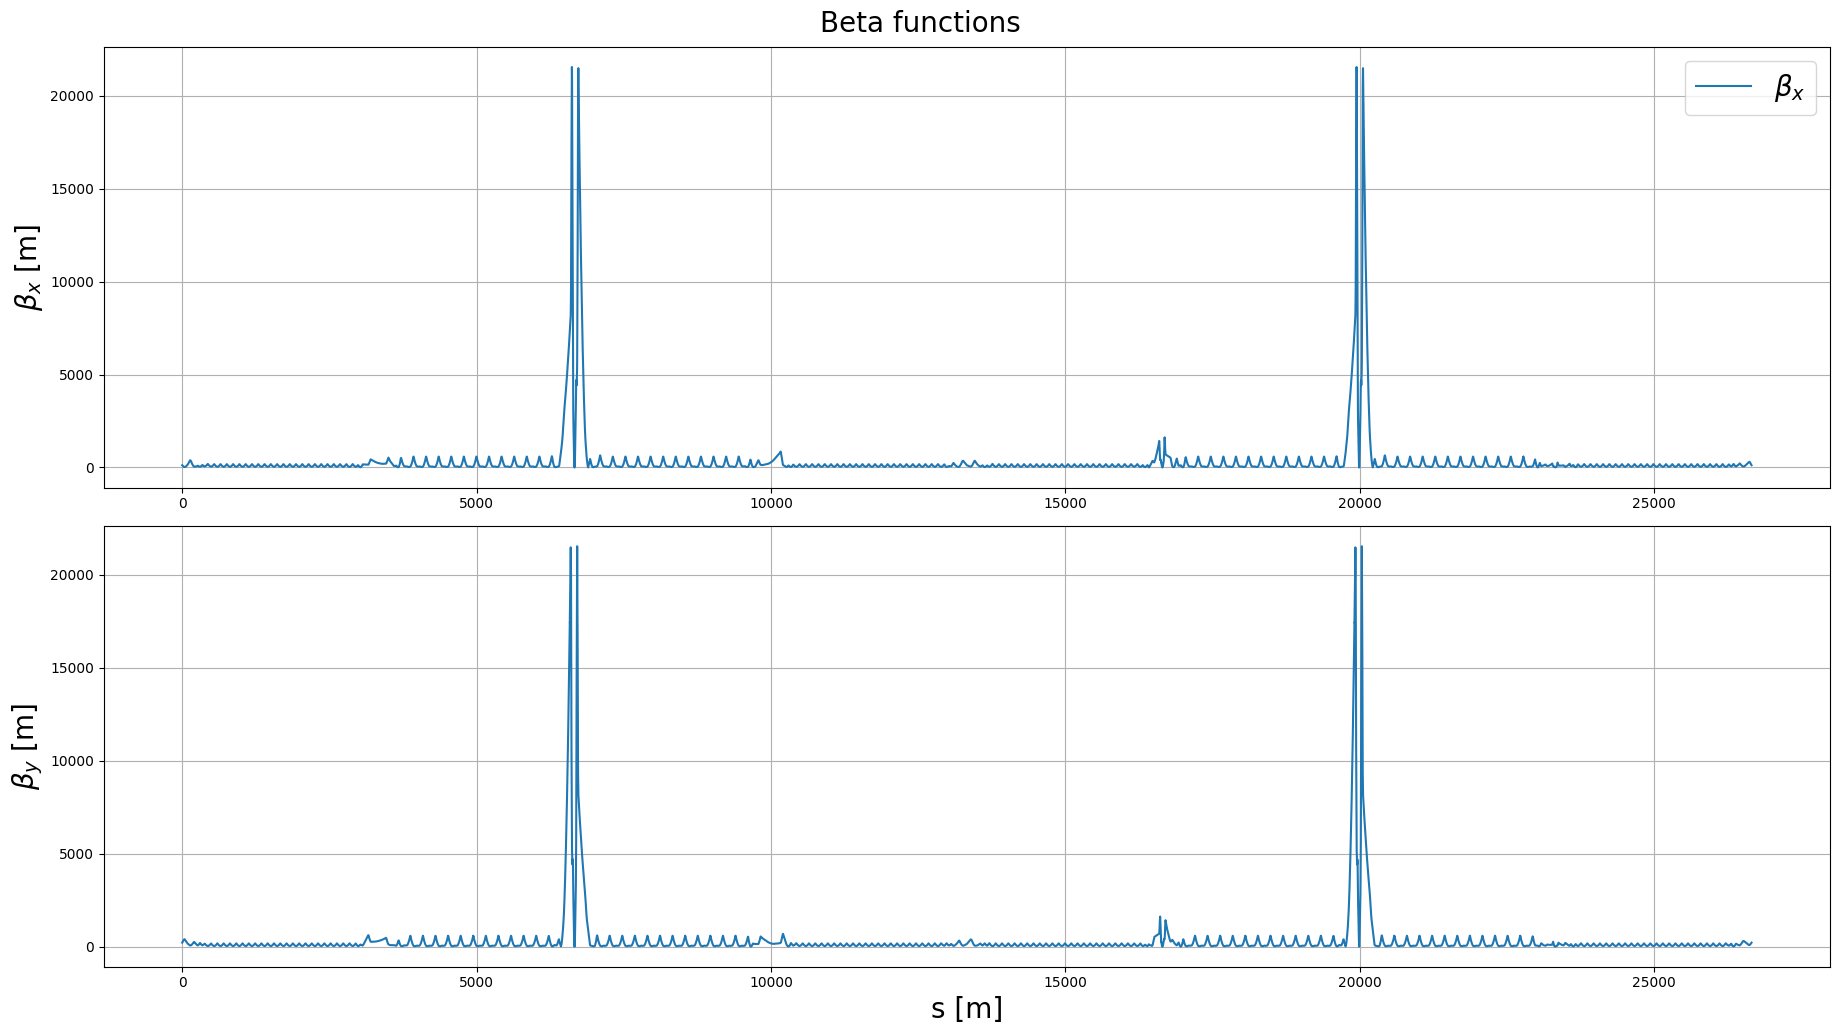

In [4]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
fontsize = 20
fig.suptitle('Beta functions',fontsize = fontsize )
ax[0].plot(twiss_b1['s'], twiss_b1['betx'], label = r'$\beta_{x}$')
ax[0].set_ylabel(r'$\beta_{x}$ [m]', fontsize = fontsize)
ax[0].grid()
ax[0].legend(fontsize = fontsize)

ax[1].plot(twiss_b1['s'], twiss_b1['bety'], label = r'$\beta_{y}$')
ax[1].set_ylabel(r'$\beta_{y}$ [m]', fontsize = fontsize)
ax[1].set_xlabel('s [m]', fontsize = fontsize)
ax[1].grid()
plt.tight_layout()

mq.12r1.b1 -0.026984740997240002
mq.13r1.b1 0.02698022642198
mq.14r1.b1 -0.026984740997240002
mq.15r1.b1 0.02698022642198
mq.16r1.b1 -0.026984740997240002
mq.17r1.b1 0.02698022642198
mq.18r1.b1 -0.026984740997240002
mq.19r1.b1 0.02698022642198
mq.20r1.b1 -0.026984740997240002
mq.21r1.b1 0.02698022642198
mq.22r1.b1 -0.026984740997240002
mq.23r1.b1 0.02698022642198
mq.24r1.b1 -0.026984740997240002
mq.25r1.b1 0.02698022642198
mq.26r1.b1 -0.026984740997240002
mq.27r1.b1 0.02698022642198
mq.28r1.b1 -0.026984740997240002
mq.29r1.b1 0.02698022642198
mq.30r1.b1 -0.026984740997240002
mq.31r1.b1 0.02698022642198
mq.32r1.b1 -0.026984740997240002
mq.33r1.b1 0.02698022642198
mq.34r1.b1 -0.026984740997240002
mq.33l2.b1 0.02698022642198
mq.32l2.b1 -0.026984740997240002
mq.31l2.b1 0.02698022642198
mq.30l2.b1 -0.026984740997240002
mq.29l2.b1 0.02698022642198
mq.28l2.b1 -0.026984740997240002
mq.27l2.b1 0.02698022642198
mq.26l2.b1 -0.026984740997240002
mq.25l2.b1 0.02698022642198
mq.24l2.b1 -0.0269847409

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.49999998301309034


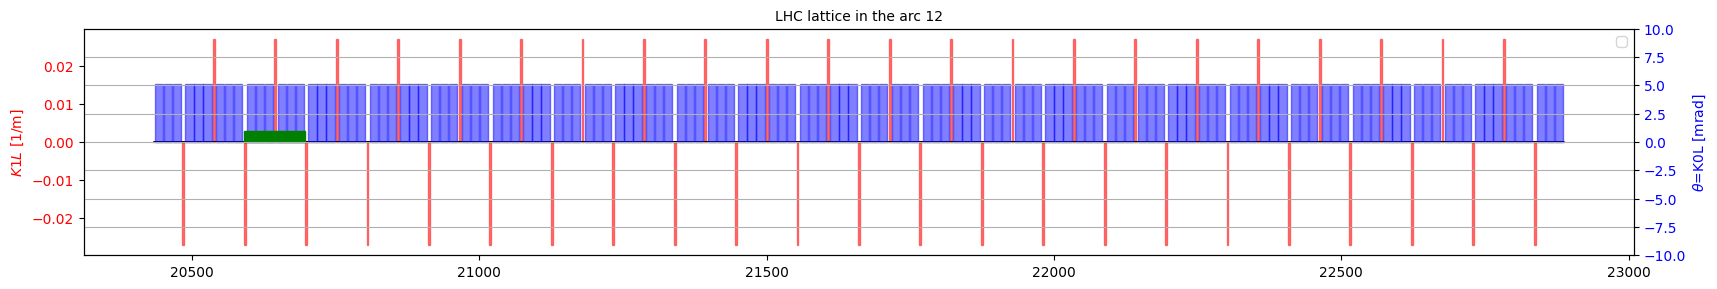

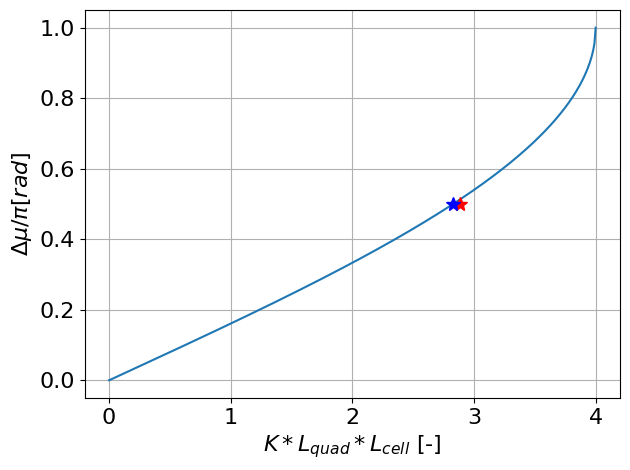

In [5]:
import matplotlib.patches as patches

def plotLatticeSeries(ax, twiss, element_name, series, height=1., v_offset=0., color='r',alpha=0.5):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (twiss_b1['s', element_name]-aux['length']*0, v_offset-height/2.),   # (x,y)
        aux['length'],          # width
        height,          # height
        color=color, alpha=alpha
    )
    )
    return;

my_dict = collider.lhcb1.to_dict()
# %%
# twiss_b1[:, ['s.arc.34.b1', 'e.arc.34.b1']]
fig = plt.figure(figsize=(20,10))

# set up subplot grid
#gridspec.GridSpec(3,3)
fontsize = 10
ax1 = plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(twiss_b1.rows['s.arc.12.b1':'e.arc.12.b1', ]['s'],0*twiss_b1.rows['s.arc.12.b1':'e.arc.12.b1', ]['s'],'k')
# plt.plot(twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['s'][0:300],twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['x'][0:300]*1e4,'green',label='x')


for ii in (twiss_b1.rows['s.arc.12.b1':'e.arc.12.b1', ]['name']):
    if((ii.startswith('mq.')) and ii.endswith('b1')):
        
        aux =my_dict['elements'][ii]
        k1l = my_dict['elements'][ii]['k1']*my_dict['elements'][ii]['length']
        print(ii, k1l)
        plotLatticeSeries(plt.gca(),twiss_b1, ii, aux, height=k1l, v_offset=k1l/2, color='red')
        if(ii == 'mq.14r3.b1'):
             break
ax1.set_ylabel(r'$K1L$ [1/m]', color='red')  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor='red')

FODO_cell_length = twiss_b1['s','mq.14r1.b1']-twiss_b1['s','mq.12r1.b1']
fodo_cell = patches.Rectangle(( twiss_b1['s','mq.14r1.b1'], 0),
                              FODO_cell_length, 1, linewidth=1, edgecolor='green', facecolor='green')

#ax1.set_xlim(twiss_b1.rows['s.arc.34.b1':'e.arc.34.b1', ]['s'][0],600)

ax2 = ax1.twinx() 
ax2.set_ylim(-10,10)
for ii in (twiss_b1.rows['s.arc.12.b1':'e.arc.12.b1', ]['name']):
    if((ii.startswith('mb.')) and ii.endswith('b1')):
        # print(ii)
        aux =my_dict['elements'][ii]
        kl = my_dict['elements'][ii]['k0']*my_dict['elements'][ii]['length']
        plotLatticeSeries(plt.gca(),twiss_b1, ii, aux, height=kl*1000, v_offset=kl/2*1000, color='blue')
        # if(ii == 'mb.c15r3.b1'):
        #     break

plt.gca().add_patch(fodo_cell)
color = 'blue'
ax2.set_ylabel(r'$\theta$=K0L [mrad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
plt.title('LHC lattice in the arc 12', fontsize = fontsize)
plt.xlabel('s [m]', fontsize = fontsize)
plt.legend(fontsize = fontsize)
plt.grid()

#%%

x= np.arange(0,4.01,0.01)
y=2*np.arcsin(x/4)/np.pi
fig, ax1 = plt.subplots()
ax1.plot(x,y,'-')
ax1.set_ylabel("$\Delta \mu / \pi [rad]$", fontsize=16)
ax1.set_xlabel("$K*L_{quad}*L_{cell}$ [-]", fontsize=16)
ax1.grid()
ax1.tick_params(axis='both', labelsize=16)
phase_advance = np.abs((twiss_b1['mux','mq.31r1.b1']-twiss_b1['mux','mq.33l2.b1']))
print(phase_advance)
LHCFODO = np.abs(k1l)*FODO_cell_length
#plot a star at x = LHCFODO, y = np.pi/2
ax1.plot(LHCFODO, phase_advance, '*', markersize=10, color='red')
#find the point corresponding to y = 0.4
x0 = 4*np.sin(phase_advance*np.pi/2)
ax1.plot(x0, phase_advance, '*', markersize=10, color='blue')


plt.tight_layout()